In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import string 
import os 
import warnings 

#ML 
import tensorflow as tf
import keras.utils as ku
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import ModelCheckpoint

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)


Using TensorFlow backend.


# Loading the Dataset

In [2]:
df = pd.read_csv("Shakespeare_data.csv") 

In [3]:
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [4]:
lines_num = [lines for lines in df.PlayerLine]
print(len(lines_num))

111396


# Data Preprocessing

In [5]:
def text_cleaner(txt):
    txt = "".join(a for a in txt if a not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii", "ignore")
    return txt

In [6]:
text_corpus = [text_cleaner(x) for x in lines_num]
text_corpus[:10]

['act i',
 'scene i london the palace',
 'enter king henry lord john of lancaster the earl of westmoreland sir walter blunt and others',
 'so shaken as we are so wan with care',
 'find we a time for frighted peace to pant',
 'and breathe shortwinded accents of new broils',
 'to be commenced in strands afar remote',
 'no more the thirsty entrance of this soil',
 'shall daub her lips with her own childrens blood',
 'nor more shall trenching war channel her fields']

In [7]:
#Tokenizer
tokenizer = Tokenizer()

def get_token_seq(corpus):
    corpus = corpus[:7000]
    tokenizer.fit_on_texts(corpus)
    total_num_words = len(tokenizer.word_index) + 1
    
    #Converting the data to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        
        for i in range(1, len(token_list)):
            n_gram_seq = token_list[:i+1]
            input_sequences.append(n_gram_seq)
            
    return input_sequences, total_num_words

inp_seqs, total_words = get_token_seq(text_corpus)
inp_seqs[:20]

[[523, 4],
 [142, 4],
 [142, 4, 339],
 [142, 4, 339, 1],
 [142, 4, 339, 1, 670],
 [53, 41],
 [53, 41, 84],
 [53, 41, 84, 29],
 [53, 41, 84, 29, 124],
 [53, 41, 84, 29, 124, 3],
 [53, 41, 84, 29, 124, 3, 340],
 [53, 41, 84, 29, 124, 3, 340, 1],
 [53, 41, 84, 29, 124, 3, 340, 1, 194],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3, 354],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3, 354, 91],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3, 354, 91, 524],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3, 354, 91, 524, 423],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3, 354, 91, 524, 423, 2],
 [53, 41, 84, 29, 124, 3, 340, 1, 194, 3, 354, 91, 524, 423, 2, 375]]

In [8]:
#Generating padded sequences 
def generate_padded_seqs(input_seqs):
    max_seq_len = max([len(x) for x in input_seqs])
    input_seqs = np.array(pad_sequences(input_seqs, maxlen=max_seq_len, padding='pre'))
    
    predictors, label = input_seqs[:, :-1], input_seqs[:, -1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_seq_len

predictors, label, max_seq_len = generate_padded_seqs(inp_seqs)
predictors.shape, label.shape

((45584, 33), (45584, 6543))

# Model

In [10]:
def create_model(max_seq_len, total_words):
    input_len = max_seq_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 10, input_length=input_len))
    model.add(LSTM(512))
    model.add(Dropout(0.4))
    
    model.add(Dense(total_words, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_seq_len, total_words)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 10)            65430     
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1071104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6543)              3356559   
Total params: 4,493,093
Trainable params: 4,493,093
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(predictors, label, epochs = 30)

Epoch 1/30
45584/45584 [==============================] - 212s 5ms/step - loss: 6.8422
Epoch 2/30
45584/45584 [==============================] - 251s 5ms/step - loss: 6.5206
Epoch 3/30
45584/45584 [==============================] - 199s 4ms/step - loss: 6.3772
Epoch 4/30
45584/45584 [==============================] - 205s 4ms/step - loss: 6.2156
Epoch 5/30
45584/45584 [==============================] - 194s 4ms/step - loss: 6.0427
Epoch 6/30
45584/45584 [==============================] - 190s 4ms/step - loss: 5.8587
Epoch 7/30
45584/45584 [==============================] - 191s 4ms/step - loss: 5.6628
Epoch 8/30
45584/45584 [==============================] - 191s 4ms/step - loss: 5.4464
Epoch 9/30
45584/45584 [==============================] - 190s 4ms/step - loss: 5.1943
Epoch 10/30
45584/45584 [==============================] - 190s 4ms/step - loss: 4.9348
Epoch 11/30
45584/45584 [==============================] - 190s 4ms/step - loss: 4.6588
Epoch 12/30
45584/45584 [================

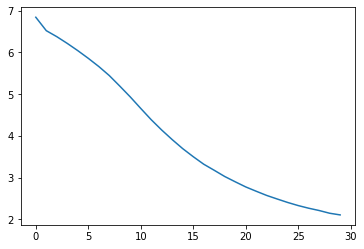

In [13]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses)

In [15]:
def generate_new_text(seed_text, new_text, model, max_seq_len):
    for _ in range(new_text):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose = 0)
        
        output_word = ""
        
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_text += " " + output_word
        
        
    return seed_text.title()

In [16]:
print("1. ", generate_new_text("Julius", 20, model, max_seq_len))
print("2. ", generate_new_text("King is", 20, model, max_seq_len))
print("3. ", generate_new_text("Thou", 20, model, max_seq_len))
print("4. ", generate_new_text("Death of", 20, model, max_seq_len))
print("5. ", generate_new_text("Romeo", 20, model, max_seq_len))

1.  Julius All The Rude Instruments Of War And Night All All It In The Field Of The Next And And And
2.  King Is The Gates Of Thy Arms Burst Of The Law Of The Ladder Ill Go The French Fly And Talbot And
3.  Thou Art No Friend In God Or Is What Is Not Go To His Duchess Fly And And The Earl Of
4.  Death Of The Right Coming Of The Dauphin Then Come And A French March And And Away And Reignier Without La Pucelle
5.  Romeo Of The Suns If Thou Didst Then Behold That Compound The Rest Of The Next Of The Mayor Of London
